In [101]:
# importo pacchetti necessari
# Data management
import pandas as pd
import pickle

# Data preprocessing and trasformation (ETL)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, FunctionTransformer, Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml, load_iris, make_moons, make_classification


# Math and Stat modules
import numpy as np
from scipy.stats import sem
from random import choice

# Supervised Learning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [57]:
# carico i dati già preparati
X = pickle.load(open(r'C:/Users/lucam/Documents/master/feature_matrix.pickle','rb'))
y  = pickle.load(open(r'C:/Users/lucam/Documents/master/employee_label.pickle','rb'))
columns_name  = pickle.load(open(r'C:/Users/lucam/Documents/master/columns_name.pickle','rb'))

In [74]:
# train test split con dimensione test 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 225)

# 1. Percettrone

In [75]:
# apprendo su training e predico sul test
perceptron = Perceptron()
perceptron.fit(X_train, y_train) 
predicted_test = perceptron.predict(X_test) 
np.sum(predicted_test == y_test)/len(y_test)

0.6895810955961332

In [81]:
# ripetizione del percettrone splittanto train e test casualmente
for _ in range(10):
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size = 0.2)
    perceptron.fit(X_train1, y_train1) 
    predicted_test = perceptron.predict(X_test1) 
    acc= np.sum(predicted_test == y_test)/len(y_test)
    print(acc)

0.6058002148227712
0.6058002148227712
0.6412459720730398
0.6509129967776585
0.6122448979591837
0.6122448979591837
0.5929108485499462
0.6143931256713212
0.3995703544575725
0.6487647690655209


- si può notare che ripetendo il percettrone per 10 volte i risultati in accuracy mostrano valori molto differenti tra loro

In [76]:
# utilizzo cross validation per avere un valore di accuracy più attendibile 
perceptron_score = cross_val_score(perceptron, X_train, y_train, cv = 5, scoring='accuracy')
perceptron_score

array([0.63758389, 0.65100671, 0.71908602, 0.67204301, 0.44354839])

In [77]:
# si calcola il valore di accuracy medio ottenuto con cross validation
np.mean(perceptron_score)

0.6246536046763368

{'whiskers': [<matplotlib.lines.Line2D at 0x238bb1fc070>,
 'caps': [<matplotlib.lines.Line2D at 0x238bb1fcd30>,
 'boxes': [<matplotlib.lines.Line2D at 0x238bb1e3fa0>,
 'medians': [<matplotlib.lines.Line2D at 0x238bb1e8d30>,
 'fliers': [<matplotlib.lines.Line2D at 0x238bb1e8700>,
 'means': [<matplotlib.lines.Line2D at 0x238bb1e8850>,
  <matplotlib.lines.Line2D at 0x238bb6e8a00>]}

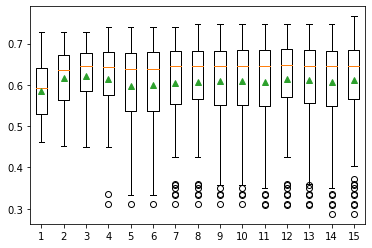

In [82]:
# definisco una funzione per valutare il percettrone con repeated k-fold
def valuta_modello_ripetizione(X, y, repeats):
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    model = Perceptron()
    scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    return scores

repeats = range(1,16)
results = list()
for i in repeats:
    scores = valuta_modello_ripetizione(X_train, y_train, i)
    results.append(scores)
plt.boxplot(results, labels = [str(i) for i in repeats], showmeans=True)

- Dal box-plot delle performance del percettrone si può notare che l'accuracy media si aggira intorno allo 0.6, e si nota un range molto ampio di accuracy

## 1.1 Valutazione percettrone

In [91]:
# definisco un classificatore dummy che predice sempre la stessa classe
mf_dum_cls = DummyClassifier(strategy='most_frequent')

In [92]:
cross_val_score(mf_dum_cls, X_train, y_train, cv=10, scoring='accuracy').mean()

0.6569049266338032

- Il classificatore dummy ha un'accuracy più elevata del percettrone 

In [93]:
train_sizes, train_scores, test_scores = learning_curve(perceptron,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 10,
                                                       n_jobs = -1,
                                                       shuffle = True)

(0.3, 0.9)

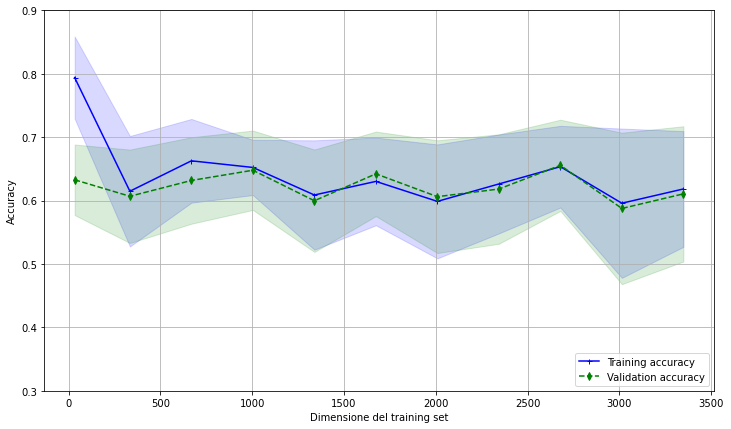

In [94]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')


ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Dimensione del training set')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')
ax.set_ylim([0.3, 0.9])

- Dalla learning curve si può vedere che la varianza dei risultati è molto alta e le performance non sono buone, fortunatamente non c'è overfitting

In [128]:
y_train_predicted = cross_val_predict(perceptron, X_train, y_train, cv = 10)

In [129]:
# confusion matrix
confusion_matrix(y_train, y_train_predicted)

array([[2271,  174],
       [ 964,  313]], dtype=int64)

In [132]:
prec=precision_score(y_train, y_train_predicted)
rec=recall_score(y_train, y_train_predicted)
f1= f1_score(y_train, y_train_predicted)
prec, rec, f1

(0.6427104722792608, 0.245105716523101, 0.354875283446712)

# 2 Regressione logistica

In [143]:
# implementazione del logistic regressor con l'opzione di decision_function per permettere di modificare la soglia
logit_cls = LogisticRegression(max_iter=1000)
y_scores = cross_val_predict(logit_cls, X_train, y_train, cv = 10, method='decision_function')

In [144]:
prec, recall, soglia = precision_recall_curve(y_train, y_scores)

Text(0, 0.5, 'Precision')

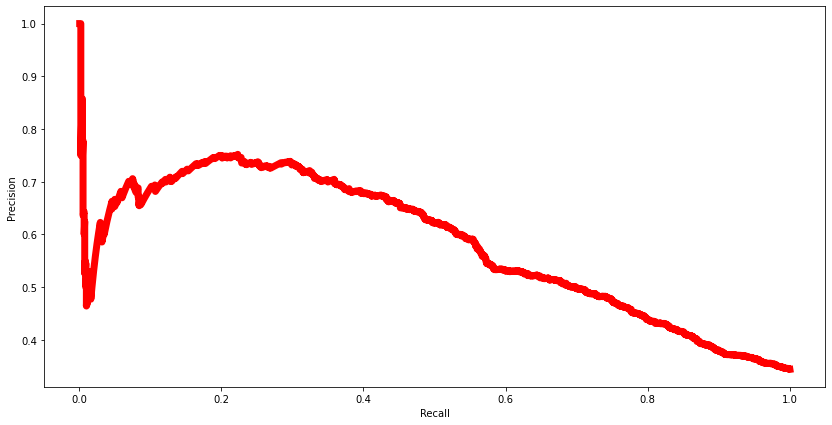

In [147]:
# precision in funzione della recall
fig_prf = plt.figure(figsize=(14,7))
ax = fig_prf.add_subplot()
ax.plot(recall[:-1], prec[:-1], 'r', label = 'precision', lw = 7)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

Text(0, 0.5, 'Recall')

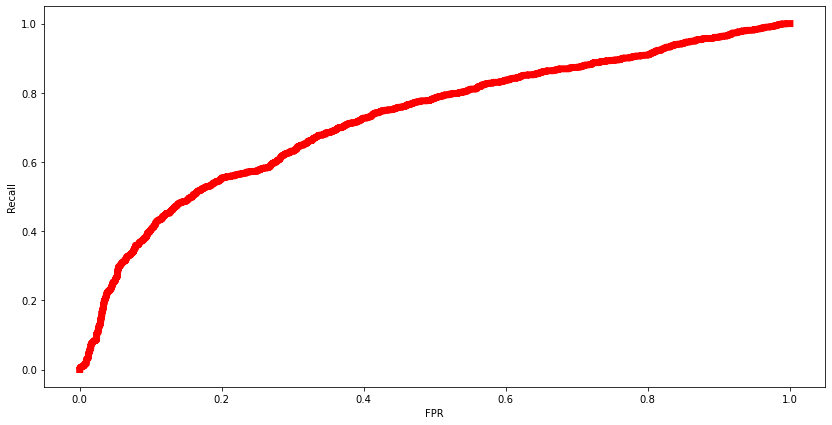

In [148]:
# visualizzazione della ROC curve (recall in funzione del false positive rate)
fpr, recall, soglia = roc_curve(y_train, y_scores)
fig_roc = plt.figure(figsize=(14,7))
ax = fig_roc.add_subplot()
ax.plot(fpr, recall, 'r', label = 'recall', lw = 7)
ax.set_xlabel("FPR")
ax.set_ylabel("Recall")

In [149]:
train_sizes, train_scores, test_scores = learning_curve(logit_cls,
                                                       X= X_train,
                                                       y= y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 10,
                                                       n_jobs = -1,
                                                       shuffle = True)

(0.6, 1.03)

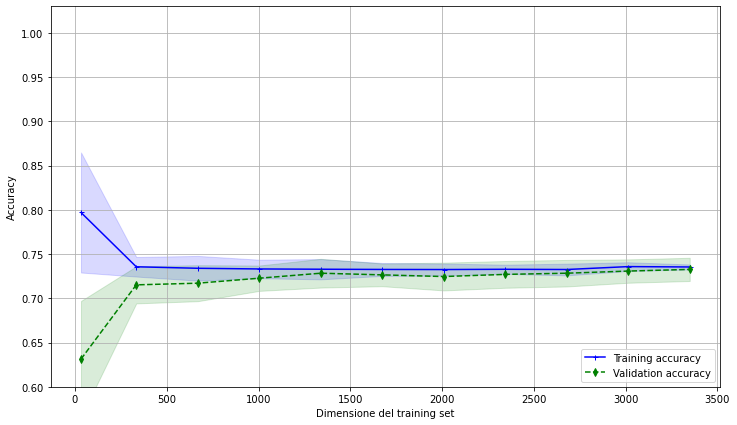

In [150]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')


ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Dimensione del training set')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 1.03])

- la validation sembra convergere quindi escludiamo la presenza di overfitting dopo 3000 istanze si sovrappongono
- probabilmente underfitting
- la varianza non è troppo elevata

In [155]:
# verifichiamo se cambiando l'iperparametro cambia le
range_C = [0.001,0.01,0.1,0.5,0.7,1]
train_scores, test_scores = validation_curve(logit_cls, X=X_train, y=y_train, param_range=range_C, param_name='C',cv=10, n_jobs=-1)

(0.0, 1.03)

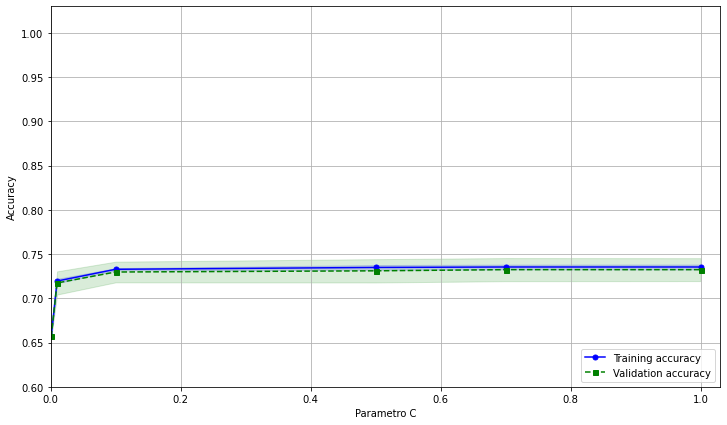

In [156]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parametro C')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 1.03])
ax.set_xlim([0., 1.03])

- Modificando l'iperparametro C non otteniamo grandi cambiamenti di performance
- Con C> 0.1 i risultati sono pressocchè gli stessi: accuracy ferma a 0.72, bassa varianza e assenza di overfitting